# Analysing Macbeth

### Importing libraries

In [1]:
import pandas as pd  # Manipulate dataframes

from gutenberg.acquire import load_etext  # Access texts
from gutenberg.cleanup import strip_headers  # Remove Project Gutenberg metadata

import re  # Search for patterns in text

import nltk  # machine learning with text

from nltk.corpus import stopwords, wordnet  # List of common words

from nltk.tokenize import word_tokenize  # Split text into significant forms

from nltk.stem import WordNetLemmatizer  # Reduce words to their root form ("lemma")

from nltk import pos_tag  # Tag words with parts of speech

from collections import defaultdict  # Dictionaries that have a backup value

from sklearn.feature_extraction.text import CountVectorizer  # Convert text to sparse matrices

import matplotlib.pyplot as plt  # Complex visualisation configuration

import seaborn as sns  # Visualisation

from wordcloud import WordCloud  # Create wordclouds

from textblob import TextBlob  # Sentiment analysis

from nltk.sentiment.vader import SentimentIntensityAnalyzer  # Sentiment analysis

from gensim.models.ldamodel import LdaModel  # Topic extraction

from gensim.models.phrases import Phrases  # ngrams

from gensim import corpora  # Vectorization

import pyLDAvis.gensim  # Visualise topics

### Sourcing data 

In [2]:
# Load the text from a file

with open("macbeth_text.txt", "r") as f:
    raw_text = f.read()

In [3]:
# Remove in-line stage directions

raw_text = re.sub(r"\[[\S\s]+?\]", "", raw_text)

In [4]:
# Split text into lines

lines = raw_text.split("\n")

In [5]:
# Remove lines with no content

lines = list(filter(lambda x: len(x) > 0, lines))

In [6]:
# Mark specific lines for separation

def mark_line(line):
    if line[0] == " ":
        if line[-1] != ".":
            return "Stage_dir" + line + "."
        else:
            return "Stage_dir" + line
    elif "ACT " in line or "SCENE " in line:
        return line + "."
    return line
    
lines = [mark_line(line) for line in lines]

In [7]:
# Join all the text back together again

raw_text = "\n".join(lines)

In [8]:
# Split the text by sentences instead

sentences = re.sub("\n{2,}", " ", raw_text)
sentences = re.sub(r"\s+", " ", sentences)
sentences = re.sub("([.?!])", r"\1SPLIT_ME", sentences)
sentences = re.split("SPLIT_ME", sentences)

# Remove introductory data, keeping only the text
sentences = sentences[110:]

In [9]:
act = 0
scene = 0
speaker = ""
parsed_sentences = []

for sentence in sentences:
    if "ACT" in sentence:
        act += 1
    if "SCENE" in sentence:
        scene += 1
        speaker = ""
    elif sentence.upper() == sentence:
        speaker = sentence.strip()[:-1].title()
    elif "STG_DIR" not in sentence:
        parsed_sentences.append((act, scene, speaker, sentence.strip()))

In [10]:
# Convert the sentences to a dataframe

macbeth_df = pd.DataFrame(columns=["act", "scene", "speaker", "sentence"], data=parsed_sentences)

In [11]:
# Filter out stage directions

macbeth_df = macbeth_df[~((macbeth_df["sentence"].str.contains("Stage_dir")) | (macbeth_df["speaker"] == ""))]

In [32]:
# Fix confusing character names

macbeth_df["speaker"] = macbeth_df["speaker"].replace(r'[”"]\s', "", regex=True)

# Collapse the witches together

macbeth_df["speaker"] = macbeth_df["speaker"].replace(["First Witch", "Second Witch", "Third Witch"],"Witches")

# Perform bespoke cleaning

macbeth_df.replace("_Tiger","Tiger", inplace=True)

In [13]:
macbeth_df.shape

(1321, 4)

In [14]:
# Copy the column

macbeth_df["tokens"] = macbeth_df["sentence"]

# Convert it to lowercase

macbeth_df["tokens"] = macbeth_df["tokens"].str.lower()

# Remove all non-alphanumeric characters

macbeth_df["tokens"].replace(r"\W", " ",
                             regex=True,
                             inplace=True)

# Collapse all the spaces

macbeth_df["tokens"] = macbeth_df["tokens"].replace(r"\s{2,}", " ",
                                                    regex=True).str.strip()

# Split the token column into actual tokens

macbeth_df["tokens"] = macbeth_df["tokens"].apply(word_tokenize)

In [15]:
# Lemmatize the words, reducing them back to their roots

# Object to lemmatize words 

lemma = WordNetLemmatizer()

# Dictionary to convert between part-of-speech tags and the ones the lemmatizer understands

tag_dict = defaultdict(lambda : wordnet.NOUN)
tag_dict['J'] = wordnet.ADJ
tag_dict['V'] = wordnet.VERB
tag_dict['R'] = wordnet.ADV

# function to lemmatize a sentence

def get_lemma(word):
    """Gets the POS tag for a word, and then returns the lemmatized form of the word"""
    tag = pos_tag([word])[0][1][0]
    tag = tag_dict[tag]
    
    return lemma.lemmatize(word, tag)

# Actually perform the lemmatization

macbeth_df["tokens"] = macbeth_df["tokens"].apply(lambda x:
                                                  [get_lemma(word) for word in x])

In [16]:
# Remove common words

stop_words = stopwords.words("english")
stop_words.extend(["thou", "thee", "thy", "hath"])


# Filter the words, removing the ones in stop_words and those of <=2 letters
macbeth_df["tokens"] = macbeth_df["tokens"].apply(lambda x: [y for y in x if y not in stop_words
                                                              and len(y) > 2])

In [17]:
# Join the lists of words back into strings

macbeth_df["tokens"] = macbeth_df["tokens"].apply(lambda x: " ".join(x))

In [18]:
# Fix the index

macbeth_df.reset_index(inplace=True, drop=True)

In [19]:
# Calculate sentiment from the tokens

sid = SentimentIntensityAnalyzer()

macbeth_df["sentiment"] = macbeth_df["tokens"].apply(lambda x: sid.polarity_scores(x)["compound"])

In [20]:
# Create a document-term matrix

# Create an object that converts strings into a sparse matrix

vectorizer = CountVectorizer(max_features= 10000 , min_df=0.01, ngram_range= (1,1))

# Convert the text column to a sparse matrix

macbeth_dtm = vectorizer.fit_transform(macbeth_df["tokens"])

In [21]:
# Create a dataframe of terms and frequencies

# Get the frequency of each term

term_frequencies = macbeth_dtm.sum(axis=0)

# Match frequencies to terms

frequent_terms = [(word, term_frequencies[0, id]) for word, id in vectorizer.vocabulary_.items()]

# Convert the word-frequency pairings to a dataframe

term_df = pd.DataFrame(columns=["term",
                                   "frequency"], data=frequent_terms)

# Sort the dataframe

term_df.sort_values(by="frequency", ascending=False, inplace=True)

In [22]:
term_df.head(5)

,term,frequency
3,come,76
0,shall,66
1,upon,63
52,make,61
50,yet,57


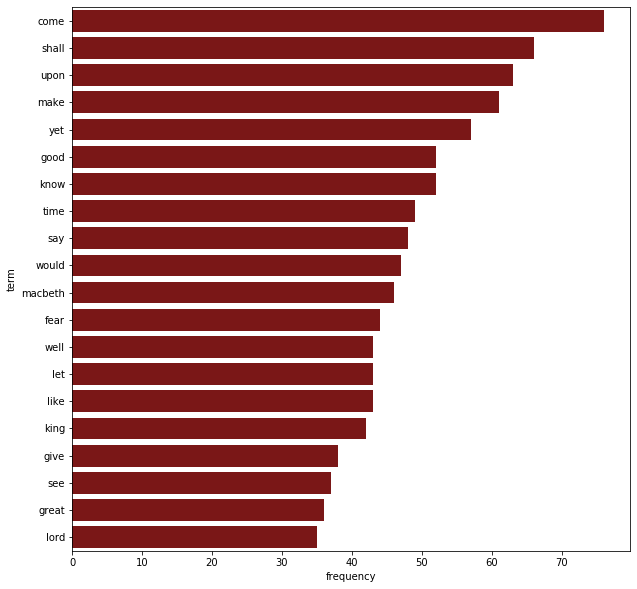

In [23]:
# Set figure size

plt.figure(figsize = (10,10))

# Plot the most frequent terms

sns.barplot(x="frequency", y="term", color="#8A0707", data=term_df.head(20))

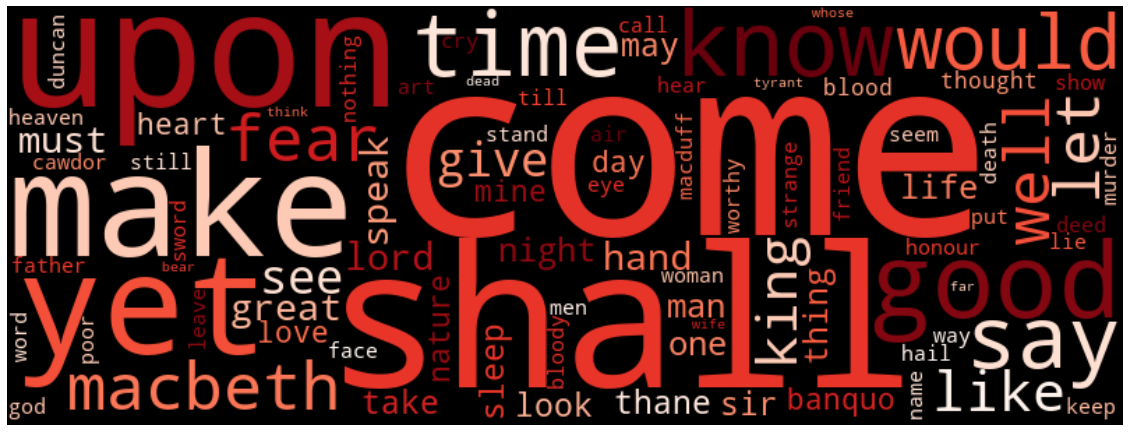

In [24]:
# Create a dictionary of most frequent terms ((required for word clouds)

term_dict = term_df.set_index('term')['frequency'].to_dict()

# Create a wordcloud of most frequent terms

wc = WordCloud(width=800, height=300, colormap="Reds",
               max_words=100)

wc.generate_from_frequencies(term_dict)

# Display the cloud

plt.figure(figsize=(20, 10))

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Enter a character: Lady Macbeth


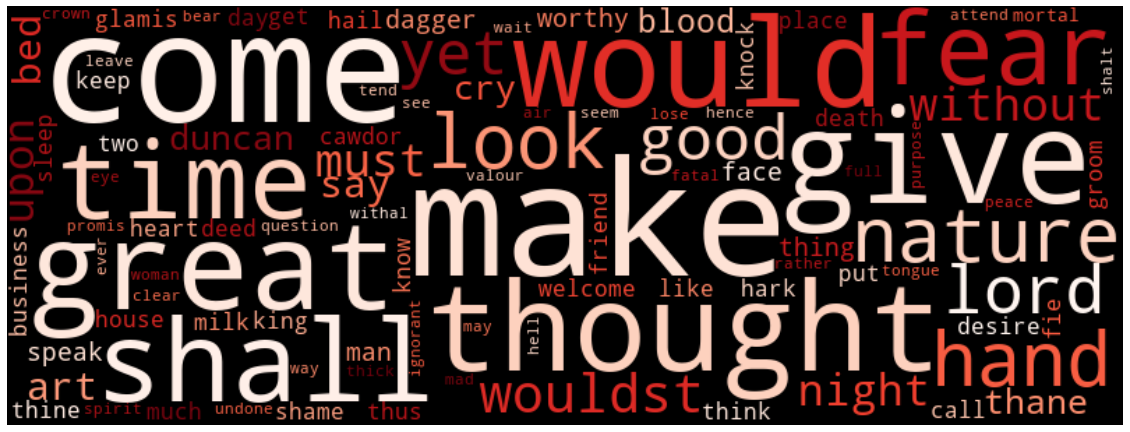

In [34]:
# Function to generate a word cloud for a specific character

def generate_speaker_word_cloud(df, speaker):
    df = df[df["speaker"] == speaker]
    vectorizer = CountVectorizer(max_features= 10000 , min_df=0.01, ngram_range= (1,1))
    dtm = vectorizer.fit_transform(df["tokens"])
    term_frequencies = dtm.sum(axis=0)
    frequent_terms = [(word, term_frequencies[0, id]) for word, id in vectorizer.vocabulary_.items()]
    term_dict = dict(frequent_terms)
    wc = WordCloud(width=800, height=300, colormap="Reds",
               max_words=100)
    wc.generate_from_frequencies(term_dict)

    plt.figure(figsize=(20, 10))

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

character = input("Enter a character: ")

generate_speaker_word_cloud(macbeth_df, character)

In [33]:
list(macbeth_df["speaker"].unique())

['Witches',
 'All',
 'Duncan',
 'Malcolm',
 'Soldier',
 'Lennox',
 'Ross',
 'Macbeth',
 'Banquo',
 'Angus',
 'Lady Macbeth',
 'Messenger',
 'Fleance',
 'Porter',
 'Macduff',
 'Macbeth, Lennox',
 'Donalbain',
 'Old Man',
 'Servant',
 'First Murderer',
 'Second Murderer',
 'Both Murderers',
 'Third Murderer',
 'Lords',
 'Murderer',
 'Hecate',
 'Lord',
 'Apparition',
 'Lady Macduff',
 'Son',
 'Doctor',
 'Gentlewoman',
 'Menteith',
 'Caithness',
 'Seyton',
 'Siward',
 'Soldiers',
 'Young Siward']